# Explicit Sampling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/markean/aimz/blob/main/docs/notebooks/sampling.ipynb)

aimz provides three sets of explicit sampling methods from the `ImpactModel` class, similar to [PyMC](https://www.pymc.io/projects/docs/en/stable/api/samplers.html) samplers:

1. **Prior Predictive Sampling**: `.sample_prior_predictive_on_batch()` and `.sample_prior_predictive()`.
2. **Posterior Sampling**: `.sample()`.
3. **Posterior Predictive Sampling**: `.sample_posterior_predictive_on_batch()` and `.sample_posterior_predictive()`.

By default, these methods return results as an `xarray.DataTree`, with the relevant group labeled as `prior_predictive`, `posterior`, or `posterior_predictive`. For some methods, setting `return_datatree=False` instead returns a `dict`.

The prior predictive sampling methods perform forward sampling based on the model’s prior specification in the `kernel` and are not part of the standard training and inference workflow (`.fit()`/`.predict()`), making them particularly useful for conducting prior predictive checks.

Unlike `.fit()` or `.fit_on_batch()`, `.sample()` does not modify the internal `posterior` attribute. 
It is primarily intended for drawing posterior samples from a fitted model using variational inference. 
Users can update the internal posterior manually by passing the samples obtained from `.sample()` to `.set_posterior_samples()` without retraining the model.

The posterior predictive sampling methods serve as convenient aliases for `.predict_on_batch()` and `.predict()`, respectively.

In [1]:
import jax.numpy as jnp
import numpyro.distributions as dist
import xarray as xr
from arviz_plots import plot_ppc_dist, style
from jax import random
from jax.typing import ArrayLike
from numpyro import optim, plate, sample
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal

from aimz import ImpactModel

style.use("arviz-variat")

%config InlineBackend.figure_format = "retina"

%load_ext watermark

A minimal linear regression model and synthetic data are defined as an example below.

In [2]:
def model(X: ArrayLike, y: ArrayLike | None = None) -> None:
    """Linear regression model."""
    w = sample("w", dist.Normal().expand((X.shape[1],)))
    b = sample("b", dist.Normal())
    mu = jnp.dot(X, w) + b
    sigma = sample("sigma", dist.Exponential())
    with plate("data", size=X.shape[0]):
        sample("y", dist.Normal(mu, sigma), obs=y)


rng_key = random.key(42)
rng_key, rng_key_w, rng_key_b, rng_key_x, rng_key_e = random.split(rng_key, 5)
w = random.normal(rng_key_w, (5,))
b = random.normal(rng_key_b)
X = random.normal(rng_key_x, (1000, 5))
e = random.normal(rng_key_e, (1000,))
y = jnp.dot(X, w) + b + e


rng_key, rng_subkey = random.split(rng_key)
im = ImpactModel(
    model,
    rng_key=rng_subkey,
    inference=SVI(
        model,
        guide=AutoNormal(model),
        optim=optim.Adam(step_size=1e-3),
        loss=Trace_ELBO(),
    ),
)

Backend: cpu, Devices: 1


## Prior Predictive Sampling

Before training the model, we draw prior predictive samples and visualize the prior predictive distribution:

<xarray.DataTree 'root'>
Group: /
└── Group: /prior_predictive
        Dimensions:  (chain: 1, draw: 100, y_dim_0: 1000)
        Coordinates:
          * chain    (chain) int64 8B 0
          * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
          * y_dim_0  (y_dim_0) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
        Data variables:
            y        (chain, draw, y_dim_0) float32 400kB -0.4827 0.5957 ... -0.3813
        Attributes:
            created_at:    2025-09-27T19:42:11.911146+00:00
            aimz_version:  0.7.0

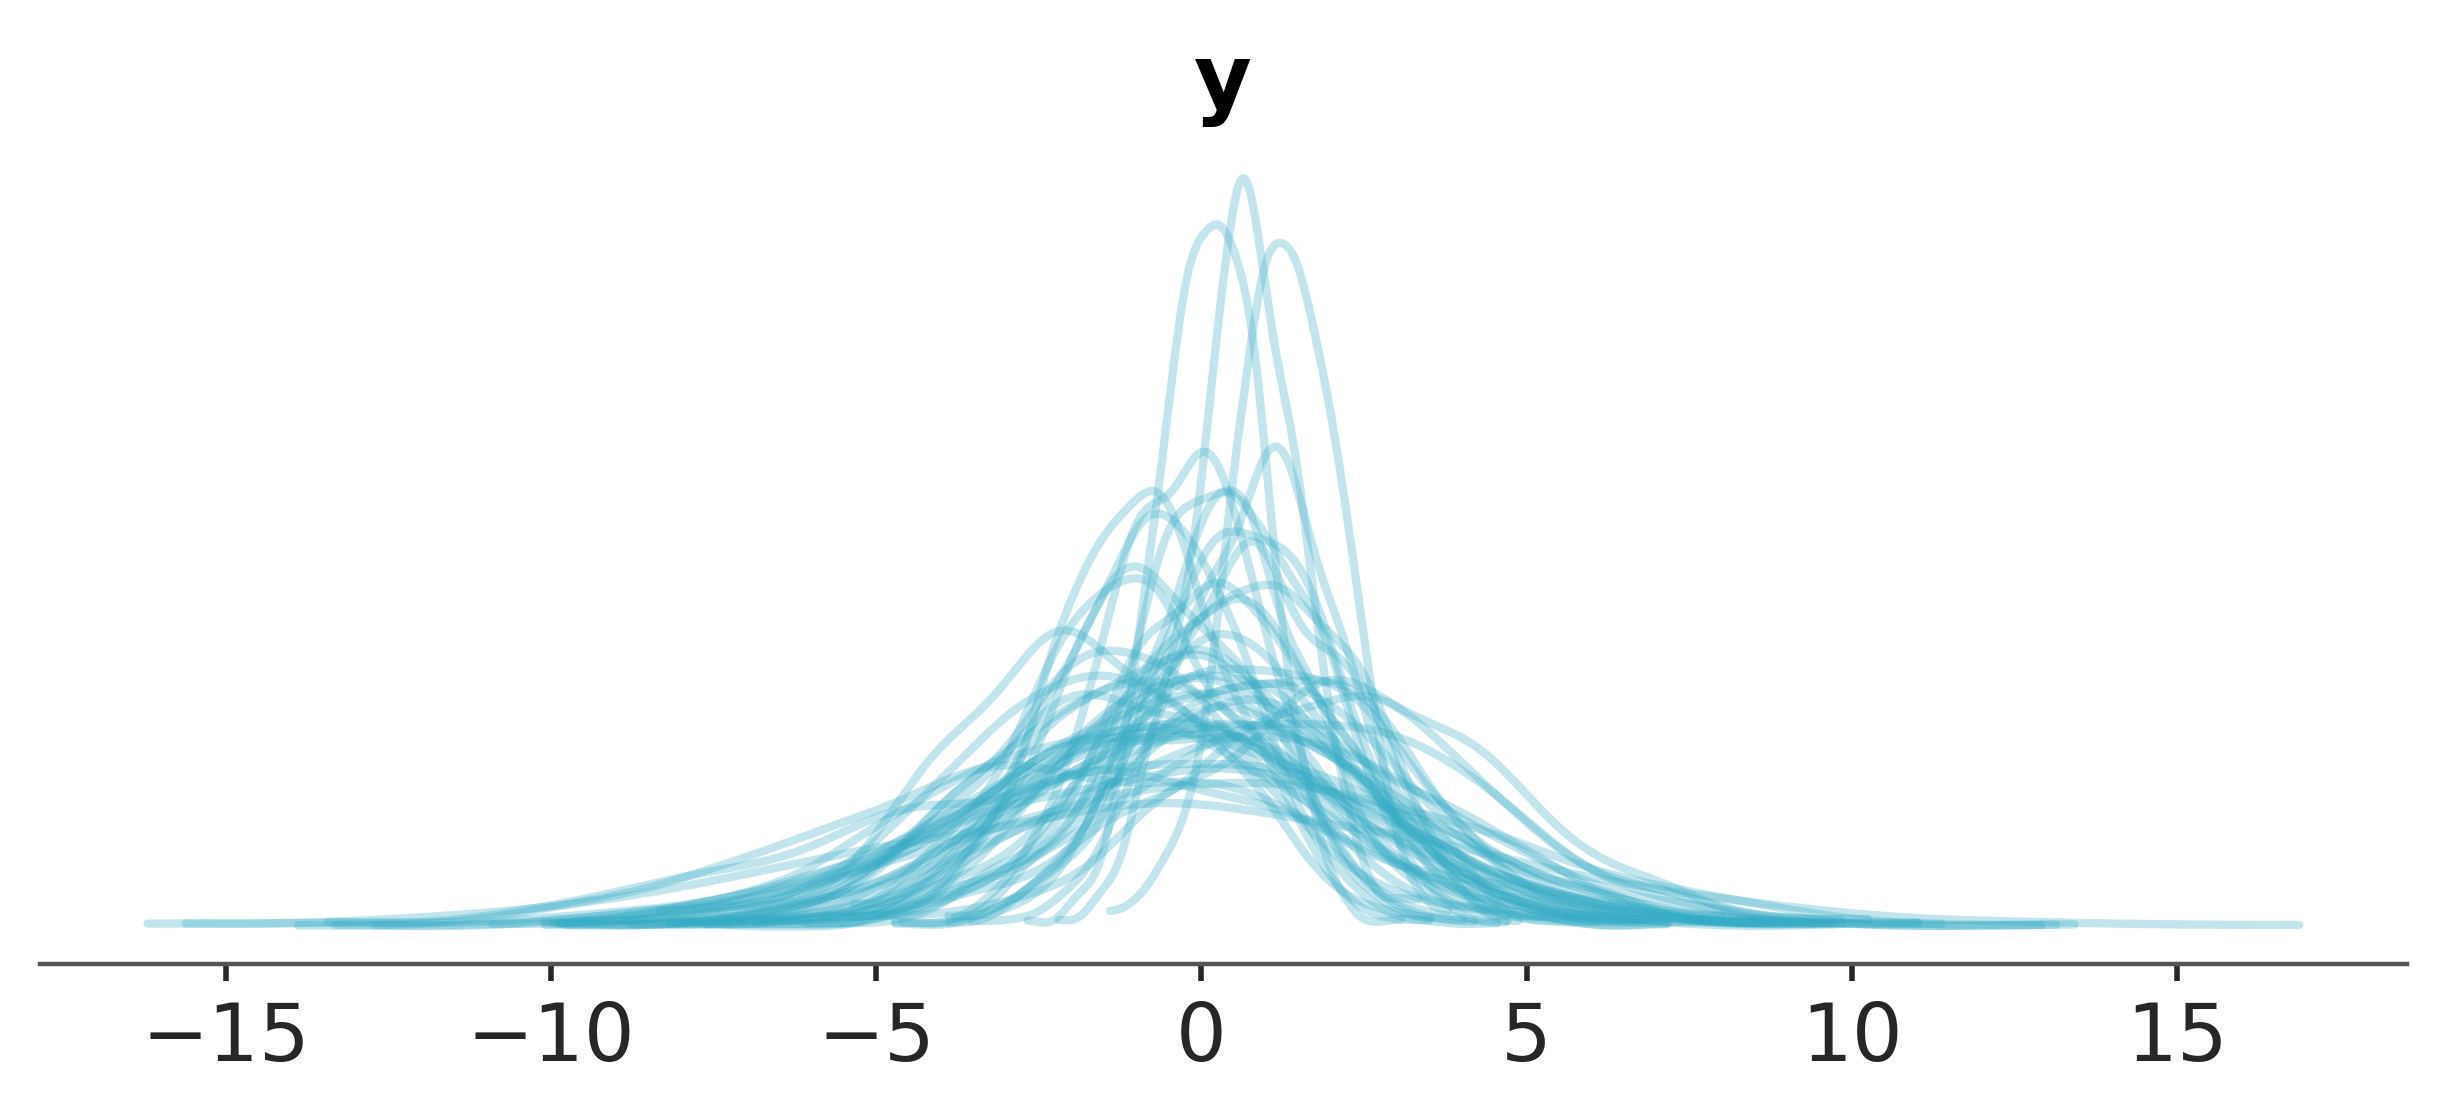

In [3]:
dt = im.sample_prior_predictive_on_batch(X, num_samples=100)
plot_ppc_dist(dt, var_names="y", group="prior_predictive")
dt

## Posterior Sampling

We first train the model using variational inference, drawing only a single posterior sample for demonstration purposes. After fitting, we call `.sample()` to generate 100 posterior samples for further analysis. Setting `return_datatree=False` ensures that the results are returned as a dictionary rather than an `xarray.DataTree`.

In [4]:
im.fit_on_batch(X, y, num_samples=1, progress=False)
posterior_samples = im.sample(num_samples=100, return_datatree=False)

Performing variational inference optimization...
Posterior sampling...


We pass posterior samples to `.set_posterior_samples()` to update the model’s internal `posterior`:

In [5]:
im.set_posterior_sample(posterior_samples);

## Posterior Predictive Sampling

We draw posterior predictive samples from the fitted model using `.sample_posterior_predictive_on_batch()`, though the same results can be obtained with `.predict_on_batch()`(or `.predict()`). 
The posterior group now contains 100 posterior samples.

In [6]:
dt_posterior_predictive = im.sample_posterior_predictive_on_batch(X)
dt_posterior_predictive

<xarray.DataTree 'root'>
Group: /
├── Group: /posterior
│       Dimensions:  (chain: 1, draw: 100, w_dim_0: 5)
│       Coordinates:
│         * chain    (chain) int64 8B 0
│         * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
│         * w_dim_0  (w_dim_0) int64 40B 0 1 2 3 4
│       Data variables:
│           b        (chain, draw) float32 400B 0.3868 0.4323 0.4526 ... 0.485 0.3385
│           sigma    (chain, draw) float32 400B 1.043 1.067 1.053 ... 1.011 1.081 1.109
│           w        (chain, draw, w_dim_0) float32 2kB 0.5985 0.8279 ... -0.611 -1.199
│       Attributes:
│           created_at:    2025-09-27T19:42:13.900487+00:00
│           aimz_version:  0.7.0
└── Group: /posterior_predictive
        Dimensions:  (chain: 1, draw: 100, y_dim_0: 1000)
        Coordinates:
          * chain    (chain) int64 8B 0
          * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
          * y_dim_0  (y_dim_0) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
        Data variables:
            y        (chain, draw, y_dim_0) float32 400kB 0.1231 2.521 ... -0.2459 4.068
        Attributes:
            created_at:    2025-09-27T19:42:13.901741+00:00
            aimz_version:  0.7.0

We join the `posterior_predictive` group from `dt_posterior_predictive` to the `dt` containing the `prior_predictive` group, and also add the `observed_data` as a new group to visualize the posterior predictive distribution.

<xarray.DataTree 'root'>
Group: /
├── Group: /prior_predictive
│       Dimensions:  (chain: 1, draw: 100, y_dim_0: 1000)
│       Coordinates:
│         * chain    (chain) int64 8B 0
│         * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
│         * y_dim_0  (y_dim_0) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
│       Data variables:
│           y        (chain, draw, y_dim_0) float32 400kB -0.4827 0.5957 ... -0.3813
│       Attributes:
│           created_at:    2025-09-27T19:42:11.911146+00:00
│           aimz_version:  0.7.0
├── Group: /posterior_predictive
│       Dimensions:  (chain: 1, draw: 100, y_dim_0: 1000)
│       Coordinates:
│         * chain    (chain) int64 8B 0
│         * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
│         * y_dim_0  (y_dim_0) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
│       Data variables:
│           y        (chain, draw, y_dim_0) float32 400kB 0.1231 2.521 ... -0.2459 4.068
│       Attributes:
│           created_at:    2025-09-27T19:42:13.901741+00:00
│           aimz_version:  0.7.0
└── Group: /observed_data
        Dimensions:  (y_dim_0: 1000)
        Dimensions without coordinates: y_dim_0
        Data variables:
            y        (y_dim_0) float32 4kB ...

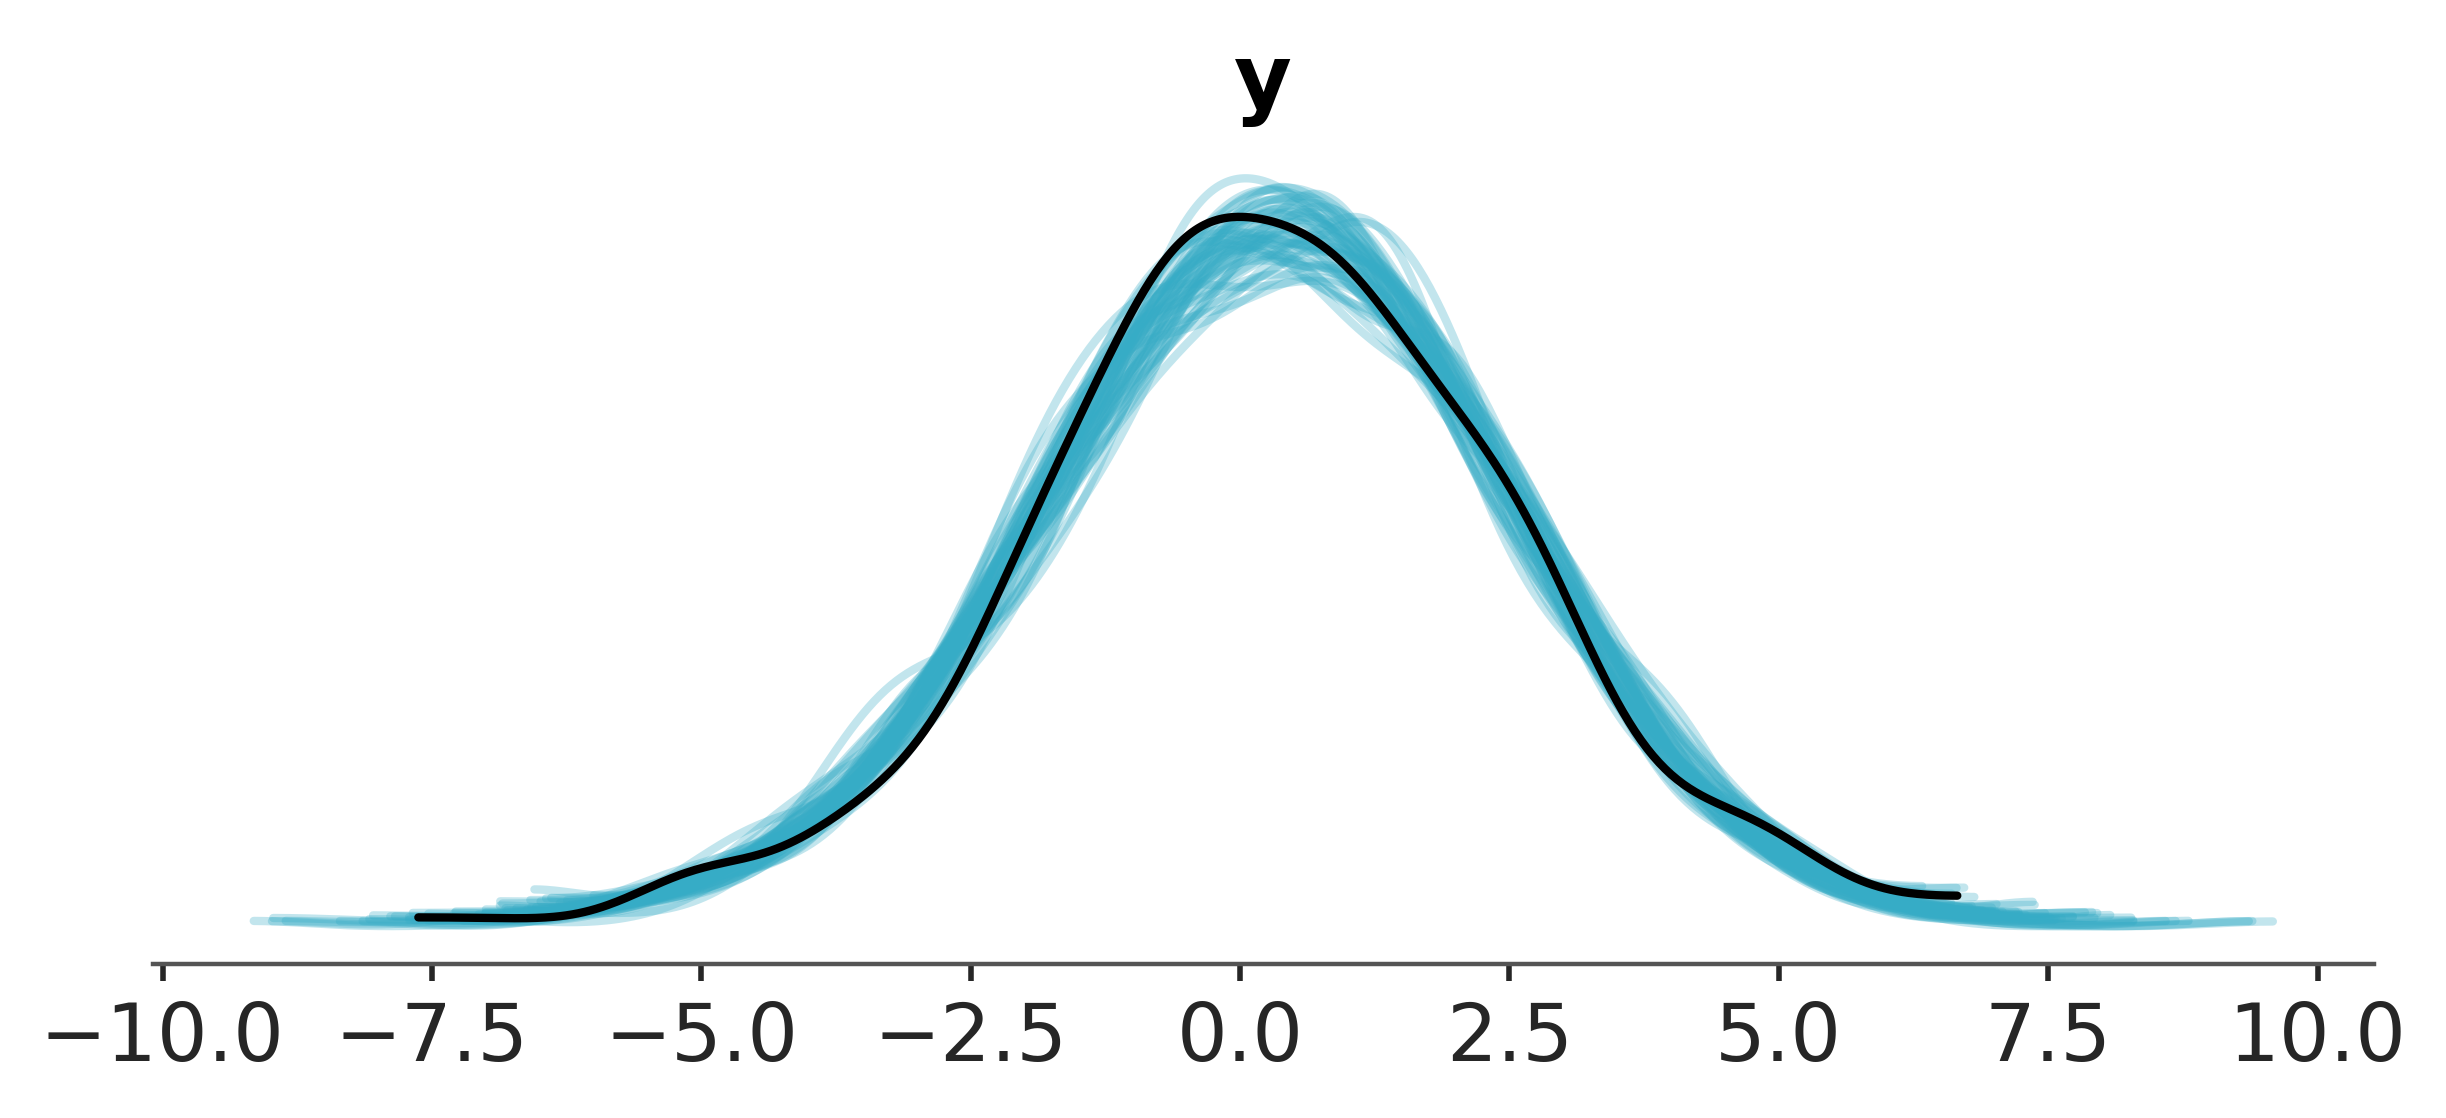

In [7]:
# Add posterior predictive samples as a new group
dt["/posterior_predictive"] = dt_posterior_predictive.posterior_predictive

# Create a dataset for observed data and add as a new group
ds = xr.Dataset({"y": xr.DataArray(y, dims=["y_dim_0"])})
dt["/observed_data"] = xr.DataTree(ds)

# Plot the posterior predictive distribution
plot_ppc_dist(dt, var_names="y")

# Display the combined DataTree
dt

In [8]:
%watermark -iv

xarray     : 2025.9.0
jax        : 0.7.2
aimz       : 0.7.0
numpyro    : 0.19.0
arviz_plots: 0.6.0

